In [229]:
import pandas as pd
import random
import numpy as np
import string
import re
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.ensemble import RandomForestClassifier
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [230]:
datasets_path  = 'D:/code_lab/twitter_sentiment_analys_training/datasets'

In [323]:
tweets = pd.read_csv(f'{datasets_path}/tweet_aug_4.csv')
tweets

,Unnamed: 0,sentimen,tweet
0,0,negatif,kata prabowo indonesia tidak dihargai bangsa a...
1,1,negatif,kata prabowo indonesia tidak dihargai bangsa a...
2,2,negatif,bercakap prabowo indonesia tidak dihargai bang...
3,3,netral,batuan langka tasbih jokowi hadiah dari habib ...
4,4,netral,batuan jarang rosario jokowi bakat dari habib ...
...,...,...,...
5440,5440,netral,bantu majukan perekonomian bangsa bersama bapa...
5441,5441,netral,bantu majukan perekonomian bangsa bangsa bersa...
5442,5442,netral,bapak jokowi mengubah cara pandang ekonomi kin...
5443,5443,netral,bapak jokowi malih cara pandang ekonomi dulu k...


In [324]:
del tweets[tweets.columns[0]]

In [325]:
tweets

,sentimen,tweet
0,negatif,kata prabowo indonesia tidak dihargai bangsa a...
1,negatif,kata prabowo indonesia tidak dihargai bangsa a...
2,negatif,bercakap prabowo indonesia tidak dihargai bang...
3,netral,batuan langka tasbih jokowi hadiah dari habib ...
4,netral,batuan jarang rosario jokowi bakat dari habib ...
...,...,...
5440,netral,bantu majukan perekonomian bangsa bersama bapa...
5441,netral,bantu majukan perekonomian bangsa bangsa bersa...
5442,netral,bapak jokowi mengubah cara pandang ekonomi kin...
5443,netral,bapak jokowi malih cara pandang ekonomi dulu k...


In [326]:
tweets['sentimen'].value_counts()

sentimen
positif    1836
netral     1821
negatif    1788
Name: count, dtype: int64

In [327]:
mapping = {
    "negatif": 0,
    "netral": 1,
    "positif": 2,
}

tweets['sentimen'] = [mapping[label] for label in tweets['sentimen']]
tweets

,sentimen,tweet
0,0,kata prabowo indonesia tidak dihargai bangsa a...
1,0,kata prabowo indonesia tidak dihargai bangsa a...
2,0,bercakap prabowo indonesia tidak dihargai bang...
3,1,batuan langka tasbih jokowi hadiah dari habib ...
4,1,batuan jarang rosario jokowi bakat dari habib ...
...,...,...
5440,1,bantu majukan perekonomian bangsa bersama bapa...
5441,1,bantu majukan perekonomian bangsa bangsa bersa...
5442,1,bapak jokowi mengubah cara pandang ekonomi kin...
5443,1,bapak jokowi malih cara pandang ekonomi dulu k...


# Split Data

In [328]:
tweets['tweet'] = tweets['tweet'].astype(str)
tweets['tweet'] = tweets['tweet'].fillna('')

In [329]:
features = tweets['tweet']
target = tweets['sentimen']

In [330]:
X = features
Y = target
# display(X)
# display(Y)

In [331]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [332]:
train_tweet, test_tweet, train_sentimen, test_sentimen = train_test_split(tweets['tweet'].to_numpy(), tweets['sentimen'].to_numpy(), test_size=0.2, random_state=0)

In [333]:
round(sum([len(i.split()) for i in train_tweet])/len(train_tweet))

24

In [334]:
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 24 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=max_length)

In [335]:
text_vectorizer

In [336]:
text_vectorizer.adapt(X_train.to_numpy())

In [337]:
sample_setence = X_train[0]
text_vectorizer([sample_setence])

<tf.Tensor: shape=(1, 24), dtype=int64, numpy=
array([[ 231,    4,   10,    8,  389,   75,  851,  336,   11,  234,  398,
        3199, 5326,   53,   72, 1699,    0,    0,    0,    0,    0,    0,
           0,    0]], dtype=int64)>

In [338]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:10] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-10:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 8184
Top 5 most common words: ['', '[UNK]', 'jokowi', 'ekonomi', 'prabowo', 'bapak', 'belum', 'gaji', 'tidak', 'itu']
Bottom 5 least common words: ['agamakristen', 'agamais', 'aduhhhh', 'adikuasa', 'adaa', 'activitas', 'acaranya', 'absolut', 'abdillah', 'abai']


# Create Embedding

In [339]:
tf.random.set_seed(42)

embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=64,
    embeddings_initializer="uniform",
    input_length=max_length,
    name="embedding_1")

embedding

In [340]:
# Get a random sentence from training set
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")
# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
menterinya aja berprestasi apalagi pemimpinnya bisa dikatakan era jokowi lah dimana sejumlah menterinya banyak berlaku kelegaan      

Embedded version:


<tf.Tensor: shape=(1, 24, 64), dtype=float32, numpy=
array([[[-0.04715041, -0.04502885,  0.0269253 , ..., -0.04094044,
          0.04728595,  0.02546448],
        [-0.03055869, -0.01405095, -0.04365781, ...,  0.01766321,
          0.00650858, -0.02361989],
        [-0.00188507, -0.00380278, -0.04707987, ..., -0.02362779,
         -0.02642873, -0.01059897],
        ...,
        [-0.03962184, -0.03749093, -0.02066393, ..., -0.03828555,
          0.00698172,  0.02110073],
        [-0.03962184, -0.03749093, -0.02066393, ..., -0.03828555,
          0.00698172,  0.02110073],
        [-0.03962184, -0.03749093, -0.02066393, ..., -0.03828555,
          0.00698172,  0.02110073]]], dtype=float32)>

In [341]:
def calculate_results(y_true, y_pred):

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [342]:
X_train_v = text_vectorizer(X_train)
X_test_v = text_vectorizer(X_test)

In [343]:
from tensorflow.keras import regularizers

In [409]:
def final_model():
  # inputs = layers.Input(shape=(1,), dtype="string")
  # x = text_vectorizer(inputs)
  # layer = embedding(x)
  # layer = layers.LSTM(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(layer)
  # layer = layers.Dense(256, name='FC1' activation='relu', kernel_regularizer=regularizers.l2(0.001))(layer)
  # layer = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(layer)
  # layer = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(layer)
  # layer = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(layer)
  # layer = layers.Activation('relu')(layer)
  # layer = layers.Dropout(0.2)(layer)
  # layer = layers.Dense(3, name='out_layer')(layer)
  # layer = layers.Activation('softmax')(layer)
  # model = tf.keras.Model(inputs=inputs, outputs=layer, name="final_model")
  # return model
  inputs = layers.Input(shape=(1,), dtype="string")
  x = text_vectorizer(inputs)
  layer = embedding(x)
  layer = layers.LSTM(128, return_sequences=True, activation='relu',)(layer)
  layer = layers.LSTM(512, activation='relu',)(layer)
  # layer = layers.Dropout(0.5)(layer)
  layer = layers.Dense(512, activation='relu',)(layer)
  # layer = layers.Dropout(0.5)(layer)
  layer = layers.Dense(512, activation='relu',)(layer)
  layer = layers.Dense(128, activation='relu',)(layer)
  layer = layers.Dropout(0.5)(layer)
  layer = layers.Dense(3, activation='softmax', name='out_layer')(layer)
  model = tf.keras.Model(inputs=inputs, outputs=layer, name="final_model")
  return model

In [410]:
fModel = final_model()
fModel.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])
fModel.summary()

Model: "final_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_944 (InputLayer)      [(None, 1)]               0         
                                                                 
 text_vectorization_3 (Text  (None, 24)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 24, 64)            640000    
                                                                 
 lstm_1243 (LSTM)            (None, 24, 128)           98816     
                                                                 
 lstm_1244 (LSTM)            (None, 512)               1312768   
                                                                 
 dense_1708 (Dense)          (None, 512)               262656    
                                                       

In [411]:
fModel_history = fModel.fit(X_train, np.float32(Y_train),
                          epochs=18,
                          batch_size=256,
                          validation_data=(X_test, np.float32(Y_test)),)

Epoch 1/18
18/18 [==============================] - 17s 838ms/step - loss: 0.8633 - accuracy: 0.6058 - val_loss: 0.7292 - val_accuracy: 0.8421
Epoch 2/18
18/18 [==============================] - 14s 798ms/step - loss: 0.3797 - accuracy: 0.8893 - val_loss: 125.2501 - val_accuracy: 0.8522
Epoch 3/18
18/18 [==============================] - 14s 802ms/step - loss: 0.1619 - accuracy: 0.9784 - val_loss: 431.1635 - val_accuracy: 0.8430
Epoch 4/18
18/18 [==============================] - 14s 807ms/step - loss: 0.0534 - accuracy: 0.9874 - val_loss: 19.1396 - val_accuracy: 0.8714
Epoch 5/18
18/18 [==============================] - 14s 776ms/step - loss: 0.0290 - accuracy: 0.9917 - val_loss: 22.9773 - val_accuracy: 0.8815
Epoch 6/18
18/18 [==============================] - 14s 790ms/step - loss: 0.0229 - accuracy: 0.9938 - val_loss: 22.0899 - val_accuracy: 0.8724
Epoch 7/18
18/18 [==============================] - 14s 781ms/step - loss: 0.0200 - accuracy: 0.9943 - val_loss: 26.4524 - val_accuracy

In [412]:
# Access the training history
train_loss = fModel_history.history['loss']
val_loss = fModel_history.history['val_loss']
train_accuracy = fModel_history.history['accuracy']
val_accuracy = fModel_history.history['val_accuracy']

In [413]:
import matplotlib.pyplot as plt

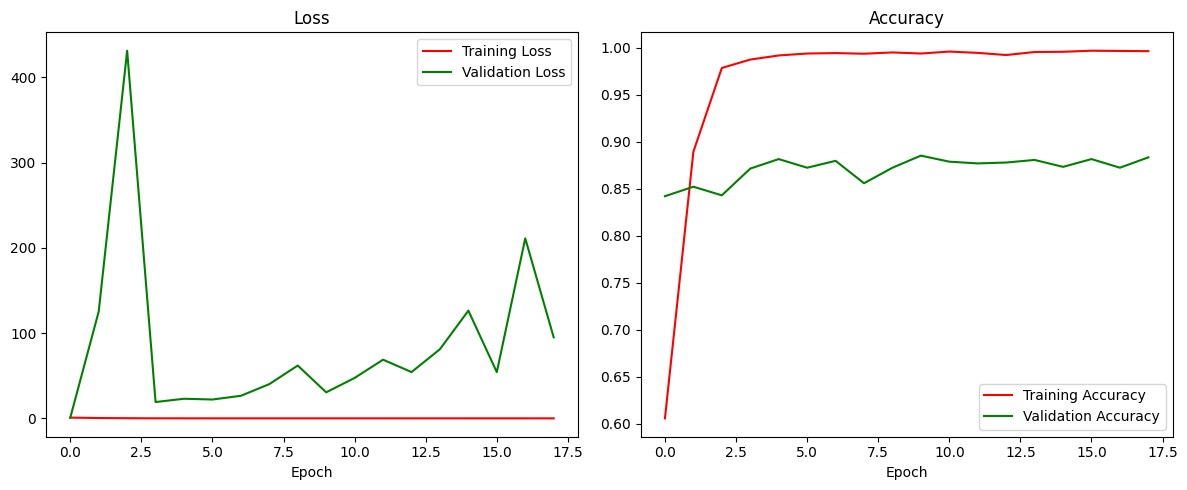

In [414]:
# Create subplots for loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', c='red')
plt.plot(val_loss, label='Validation Loss', c='green')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy', c='red')
plt.plot(val_accuracy, label='Validation Accuracy', c='green')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [415]:
# Make predictions on the validation dataset
model_F_pred_probs = fModel.predict(test_tweet)
display(model_F_pred_probs.shape, model_F_pred_probs[:10]) # view the first 10

model_F_preds = tf.squeeze(tf.round(model_F_pred_probs))
model_F_preds = np.argmax(model_F_preds, axis=1)

# Calculate LSTM model results
model_F_results = calculate_results(y_true=test_sentimen,
                                    y_pred=model_F_preds)
display(model_F_results)

display(tf.squeeze(tf.round(fModel.predict(np.array(['Pak @sandiuno dan pak @prabowo Gajinya kirim ke saya sj'])))).numpy())

35/35 [==============================] - 3s 70ms/step


(1089, 3)

array([[6.7141536e-07, 1.5257424e-06, 9.9999785e-01],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [7.1529250e-08, 5.7657630e-08, 9.9999988e-01],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [9.9309582e-01, 5.8257924e-03, 1.0784353e-03],
       [2.0494795e-09, 1.3606151e-09, 1.0000000e+00],
       [1.5017004e-07, 1.3771721e-07, 9.9999976e-01]], dtype=float32)

{'accuracy': 88.42975206611571,
 'precision': 0.8846729914029579,
 'recall': 0.8842975206611571,
 'f1': 0.88444225164958}

1/1 [==============================] - 0s 21ms/step


array([0., 1., 0.], dtype=float32)

# Model 1

In [368]:
def model1():

  inputs = layers.Input(shape=(1,), dtype="string")
  x = text_vectorizer(inputs)
  layer = embedding(x)
  layer = layers.LSTM(32)(layer)
  layer = layers.Dense(3, name='out_layer')(layer)
  layer = layers.Activation('softmax')(layer)
  model = tf.keras.Model(inputs=inputs, outputs=layer, name="model_1_LSTM")
  return model

In [369]:
lstm1 = model1()
lstm1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
lstm1.summary()

Model: "model_1_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_938 (InputLayer)      [(None, 1)]               0         
                                                                 
 text_vectorization_3 (Text  (None, 24)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 24, 64)            640000    
                                                                 
 lstm_1233 (LSTM)            (None, 32)                12416     
                                                                 
 out_layer (Dense)           (None, 3)                 99        
                                                                 
 activation_50 (Activation)  (None, 3)                 0         
                                                      

In [370]:
lstm1_history = lstm1.fit(X_train, np.float32(Y_train),
                          epochs=20,
                          batch_size=256,
                          validation_data=(X_test, np.float32(Y_test)),)

Epoch 1/20
18/18 [==============================] - 4s 87ms/step - loss: 1.0390 - accuracy: 0.5767 - val_loss: 0.9669 - val_accuracy: 0.6125
Epoch 2/20
18/18 [==============================] - 1s 66ms/step - loss: 0.7239 - accuracy: 0.7066 - val_loss: 0.6950 - val_accuracy: 0.6419
Epoch 3/20
18/18 [==============================] - 1s 64ms/step - loss: 0.4731 - accuracy: 0.7367 - val_loss: 0.6089 - val_accuracy: 0.7557
Epoch 4/20
18/18 [==============================] - 1s 65ms/step - loss: 0.3107 - accuracy: 0.9589 - val_loss: 0.4902 - val_accuracy: 0.8494
Epoch 5/20
18/18 [==============================] - 1s 64ms/step - loss: 0.1254 - accuracy: 0.9812 - val_loss: 0.5661 - val_accuracy: 0.8393
Epoch 6/20
18/18 [==============================] - 1s 64ms/step - loss: 0.0692 - accuracy: 0.9853 - val_loss: 0.5618 - val_accuracy: 0.8531
Epoch 7/20
18/18 [==============================] - 1s 64ms/step - loss: 0.0482 - accuracy: 0.9910 - val_loss: 0.5629 - val_accuracy: 0.8650
Epoch 8/20
18

In [371]:
test_sentimen

array([2, 1, 1, ..., 0, 1, 1], dtype=int64)

In [372]:
# Make predictions on the validation dataset
model_1_pred_probs = lstm1.predict(test_tweet)
display(model_1_pred_probs.shape, model_1_pred_probs[:10]) # view the first 10

model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds = np.argmax(model_1_preds, axis=1)

# Calculate LSTM model results
model_1_results = calculate_results(y_true=test_sentimen,
                                    y_pred=model_1_preds)
display(model_1_results)

display(tf.squeeze(tf.round(lstm1.predict(np.array(['Pak @sandiuno dan pak @prabowo Gajinya kirim ke saya sj'])))).numpy())

35/35 [==============================] - 1s 7ms/step


(1089, 3)

array([[2.0660441e-03, 3.1110428e-03, 9.9482286e-01],
       [1.0943310e-03, 9.9738997e-01, 1.5157160e-03],
       [8.6720346e-04, 9.9787533e-01, 1.2574370e-03],
       [2.3107852e-03, 1.4471320e-03, 9.9624205e-01],
       [9.9494827e-01, 2.0465606e-03, 3.0051584e-03],
       [9.9372768e-01, 2.6028366e-03, 3.6694785e-03],
       [9.9467963e-01, 2.2341690e-03, 3.0860966e-03],
       [9.9432606e-01, 2.3607707e-03, 3.3131274e-03],
       [2.7218228e-03, 1.4995603e-03, 9.9577856e-01],
       [3.3703181e-03, 2.1827875e-03, 9.9444687e-01]], dtype=float32)

{'accuracy': 86.59320477502295,
 'precision': 0.8664726552557555,
 'recall': 0.8659320477502296,
 'f1': 0.8660653098469975}

1/1 [==============================] - 0s 23ms/step


array([0., 1., 0.], dtype=float32)

In [264]:
predicted_sentiment = []

for idx in range(len(test_tweet)):
  predicted = tf.squeeze(tf.round(lstm1.predict(np.array([test_tweet[idx]])))).numpy()
  predicted_sentiment.append(predicted)

1/1 [==============================] - 0s 15ms/step


In [265]:
predicted_sentiment

[array([1., 0., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 

In [266]:
predicted_dataframe = pd.DataFrame(columns=['sentimen', 'predicted_sentimen', 'tweet'])

In [267]:
predicted_dataframe['sentimen'] = test_sentimen
predicted_dataframe['predicted_sentimen'] = [np.argmax(array) for array in predicted_sentiment]
predicted_dataframe['tweet'] = test_tweet

display(predicted_dataframe)

,sentimen,predicted_sentimen,tweet
0,1,0,mau tanya impact buat negara kek gimana kalo g...
1,1,1,jokowi raja salman sepakat tingkatkan kerja sa...
2,0,0,namanya masih ada atas paradise papers bahwasa...
3,1,1,nih apa atas gaji tidak jokowi prabowo gaji ti...
4,1,0,nan
...,...,...,...
721,0,0,nyerocos dari guru besar sumitro joyohadikusum...
722,1,0,asosiasi pengusaha bumiputera nusantara se ind...
723,0,0,tidak masuk otak lu bapak jokowi nanya ekonomi...
724,0,0,bung aids bedakan startup kayak monetizing ani...


# Model 2

In [268]:
def model2():

  inputs = layers.Input(shape=(1,), dtype="string")
  x = text_vectorizer(inputs)
  layer = embedding(x)
  layer = layers.LSTM(64)(layer)
  layer = layers.Dense(256, name='FC1')(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Dropout(0.5)(layer)
  layer = layers.Dense(3, name='out_layer')(layer)
  layer = layers.Activation('softmax')(layer)
  model = tf.keras.Model(inputs=inputs, outputs=layer)
  return model

In [269]:
lstm2 = model2()
lstm2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
lstm2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_929 (InputLayer)      [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 22)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 22, 64)            640000    
                                                                 
 lstm_1217 (LSTM)            (None, 64)                33024     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_42 (Activation)  (None, 256)               0         
                                                           

In [270]:
lstm2_history = lstm2.fit(X_train, np.float32(Y_train),
                          epochs=20,
                          batch_size=256,
                          validation_data=(X_test, np.float32(Y_test)),)

Epoch 1/20
12/12 [==============================] - 3s 87ms/step - loss: 1.0623 - accuracy: 0.6498 - val_loss: 1.0335 - val_accuracy: 0.5950
Epoch 2/20
12/12 [==============================] - 1s 53ms/step - loss: 0.7698 - accuracy: 0.8426 - val_loss: 0.7545 - val_accuracy: 0.6777
Epoch 3/20
12/12 [==============================] - 1s 54ms/step - loss: 0.1467 - accuracy: 0.9611 - val_loss: 1.8784 - val_accuracy: 0.6915
Epoch 4/20
12/12 [==============================] - 1s 53ms/step - loss: 0.0633 - accuracy: 0.9821 - val_loss: 1.6117 - val_accuracy: 0.6928
Epoch 5/20
12/12 [==============================] - 1s 53ms/step - loss: 0.0448 - accuracy: 0.9883 - val_loss: 1.4499 - val_accuracy: 0.7052
Epoch 6/20
12/12 [==============================] - 1s 54ms/step - loss: 0.0410 - accuracy: 0.9883 - val_loss: 1.4068 - val_accuracy: 0.7052
Epoch 7/20
12/12 [==============================] - 1s 53ms/step - loss: 0.0349 - accuracy: 0.9897 - val_loss: 1.4250 - val_accuracy: 0.7121
Epoch 8/20
12

In [271]:
# Make predictions on the validation dataset
model_2_pred_probs = lstm2.predict(test_tweet)
display(model_2_pred_probs.shape, model_2_pred_probs[:10]) # view the first 10

model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds = np.argmax(model_2_preds, axis=1)

# Calculate LSTM model results
model_2_results = calculate_results(y_true=test_sentimen,
                                    y_pred=model_2_preds)
display(model_2_results)

display(tf.squeeze(tf.round(lstm2.predict(np.array(['Pak @sandiuno dan pak @prabowo Gajinya kirim ke saya sj'])))).numpy())

23/23 [==============================] - 0s 4ms/step


(726, 3)

array([[9.8590267e-01, 4.2994911e-04, 1.3667422e-02],
       [8.1525795e-04, 9.9833459e-01, 8.5024413e-04],
       [9.9993372e-01, 4.8606158e-05, 1.7680708e-05],
       [3.3944231e-01, 5.9559208e-01, 6.4965591e-02],
       [1.2747359e-01, 8.0518323e-01, 6.7343235e-02],
       [5.1771110e-04, 4.0848786e-04, 9.9907374e-01],
       [1.7512067e-04, 9.9938858e-01, 4.3630393e-04],
       [4.8186108e-02, 9.4017446e-01, 1.1639414e-02],
       [3.1420463e-05, 2.6463224e-05, 9.9994206e-01],
       [9.9992204e-01, 5.8642174e-05, 1.9308320e-05]], dtype=float32)

{'accuracy': 71.21212121212122,
 'precision': 0.7216961574980705,
 'recall': 0.7121212121212122,
 'f1': 0.7125644785727799}

1/1 [==============================] - 0s 16ms/step


array([0., 1., 0.], dtype=float32)

In [272]:
predicted_sentiment = []

for idx in range(len(test_tweet)):
  predicted = tf.squeeze(tf.round(lstm2.predict(np.array([test_tweet[idx]])))).numpy()
  predicted_sentiment.append(predicted)

1/1 [==============================] - 0s 16ms/step


In [273]:
predicted_dataframe['sentimen'] = test_sentimen
predicted_dataframe['predicted_sentimen'] = [np.argmax(array) for array in predicted_sentiment]
predicted_dataframe['tweet'] = test_tweet

display(predicted_dataframe)

,sentimen,predicted_sentimen,tweet
0,1,0,mau tanya impact buat negara kek gimana kalo g...
1,1,1,jokowi raja salman sepakat tingkatkan kerja sa...
2,0,0,namanya masih ada atas paradise papers bahwasa...
3,1,1,nih apa atas gaji tidak jokowi prabowo gaji ti...
4,1,1,nan
...,...,...,...
721,0,0,nyerocos dari guru besar sumitro joyohadikusum...
722,1,0,asosiasi pengusaha bumiputera nusantara se ind...
723,0,0,tidak masuk otak lu bapak jokowi nanya ekonomi...
724,0,0,bung aids bedakan startup kayak monetizing ani...


# Model 3

In [274]:
def model3():

  inputs = layers.Input(shape=(1,), dtype="string")
  x = text_vectorizer(inputs)
  layer = embedding(x)
  layer = layers.LSTM(64)(layer)
  layer = layers.Dense(256, name='FC1')(layer)
  layer = layers.Dense(128,)(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Dropout(0.5)(layer)
  layer = layers.Dense(3, name='out_layer')(layer)
  layer = layers.Activation('softmax')(layer)
  model = tf.keras.Model(inputs=inputs, outputs=layer)
  return model

In [275]:
lstm3 = model3()
lstm3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
lstm3.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_930 (InputLayer)      [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 22)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 22, 64)            640000    
                                                                 
 lstm_1218 (LSTM)            (None, 64)                33024     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 dense_1674 (Dense)          (None, 128)               32896     
                                                           

In [276]:
lstm3_history = lstm3.fit(X_train, np.float32(Y_train),
                          epochs=20,
                          batch_size=256,
                          validation_data=(X_test, np.float32(Y_test)),)

Epoch 1/20
12/12 [==============================] - 3s 98ms/step - loss: 0.9962 - accuracy: 0.6763 - val_loss: 0.9017 - val_accuracy: 0.6102
Epoch 2/20
12/12 [==============================] - 1s 66ms/step - loss: 0.4260 - accuracy: 0.8550 - val_loss: 1.1852 - val_accuracy: 0.6997
Epoch 3/20
12/12 [==============================] - 1s 66ms/step - loss: 0.0699 - accuracy: 0.9814 - val_loss: 2.6266 - val_accuracy: 0.6915
Epoch 4/20
12/12 [==============================] - 1s 65ms/step - loss: 0.0476 - accuracy: 0.9866 - val_loss: 2.4421 - val_accuracy: 0.7039
Epoch 5/20
12/12 [==============================] - 1s 65ms/step - loss: 0.0328 - accuracy: 0.9897 - val_loss: 1.8925 - val_accuracy: 0.7094
Epoch 6/20
12/12 [==============================] - 1s 65ms/step - loss: 0.0230 - accuracy: 0.9917 - val_loss: 2.0109 - val_accuracy: 0.7163
Epoch 7/20
12/12 [==============================] - 1s 65ms/step - loss: 0.0192 - accuracy: 0.9938 - val_loss: 2.1784 - val_accuracy: 0.7190
Epoch 8/20
12

In [277]:
# Make predictions on the validation dataset
model_3_pred_probs = lstm3.predict(test_tweet)
display(model_3_pred_probs.shape, model_3_pred_probs[:10]) # view the first 10

model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds = np.argmax(model_3_preds, axis=1)

# Calculate LSTM model results
model_3_results = calculate_results(y_true=test_sentimen,
                                    y_pred=model_3_preds)
display(model_3_results)

display(tf.squeeze(tf.round(lstm3.predict(np.array(['Pak @sandiuno dan pak @prabowo Gajinya kirim ke saya sj'])))).numpy())

23/23 [==============================] - 0s 5ms/step


(726, 3)

array([[9.94160473e-01, 2.01585979e-04, 5.63786691e-03],
       [4.95185377e-04, 9.98978376e-01, 5.26444928e-04],
       [1.00000000e+00, 5.36267102e-08, 5.63591285e-10],
       [2.53371626e-01, 7.10862279e-01, 3.57660279e-02],
       [7.42599249e-01, 1.70927688e-01, 8.64731148e-02],
       [3.29676755e-06, 8.16471493e-06, 9.99988556e-01],
       [1.26195455e-05, 9.99813259e-01, 1.74157627e-04],
       [8.40293407e-01, 1.44439369e-01, 1.52672380e-02],
       [7.35400008e-08, 3.34715509e-07, 9.99999642e-01],
       [9.99999404e-01, 5.63995570e-07, 9.31325150e-09]], dtype=float32)

{'accuracy': 70.93663911845731,
 'precision': 0.7343866237015264,
 'recall': 0.709366391184573,
 'f1': 0.7090814594753742}

1/1 [==============================] - 0s 16ms/step


array([0., 1., 0.], dtype=float32)

In [278]:
predicted_sentiment = []

for idx in range(len(test_tweet)):
  predicted = tf.squeeze(tf.round(lstm3.predict(np.array([test_tweet[idx]])))).numpy()
  predicted_sentiment.append(predicted)

1/1 [==============================] - 0s 16ms/step


In [279]:
predicted_dataframe['sentimen'] = test_sentimen
predicted_dataframe['predicted_sentimen'] = [np.argmax(array) for array in predicted_sentiment]
predicted_dataframe['tweet'] = test_tweet

display(predicted_dataframe)

,sentimen,predicted_sentimen,tweet
0,1,0,mau tanya impact buat negara kek gimana kalo g...
1,1,1,jokowi raja salman sepakat tingkatkan kerja sa...
2,0,0,namanya masih ada atas paradise papers bahwasa...
3,1,1,nih apa atas gaji tidak jokowi prabowo gaji ti...
4,1,0,nan
...,...,...,...
721,0,0,nyerocos dari guru besar sumitro joyohadikusum...
722,1,0,asosiasi pengusaha bumiputera nusantara se ind...
723,0,0,tidak masuk otak lu bapak jokowi nanya ekonomi...
724,0,0,bung aids bedakan startup kayak monetizing ani...


In [280]:
print("Akurasi: ", accuracy_score(predicted_dataframe['sentimen'], predicted_dataframe['predicted_sentimen']))

Akurasi:  0.709366391184573


C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

# Model 4

In [373]:
def model4():

  inputs = layers.Input(shape=(1,), dtype="string")
  x = text_vectorizer(inputs)
  layer = embedding(x)
  layer = layers.LSTM(64)(layer)
  layer = layers.Dense(256, name='FC1')(layer)
  layer = layers.Dense(256,)(layer)
  layer = layers.Dense(256,)(layer)
  layer = layers.Dense(256,)(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Dropout(0.5)(layer)
  layer = layers.Dense(3, name='out_layer')(layer)
  layer = layers.Activation('softmax')(layer)
  model = tf.keras.Model(inputs=inputs, outputs=layer)
  return model

In [374]:
lstm4 = model4()
lstm4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
lstm4.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_939 (InputLayer)      [(None, 1)]               0         
                                                                 
 text_vectorization_3 (Text  (None, 24)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 24, 64)            640000    
                                                                 
 lstm_1234 (LSTM)            (None, 64)                33024     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 dense_1693 (Dense)          (None, 256)               65792     
                                                           

In [375]:
lstm4_history = lstm4.fit(X_train, np.float32(Y_train),
                          epochs=20, # 20
                          batch_size=256, # 256
                          validation_data=(X_test, np.float32(Y_test)),)

Epoch 1/20
18/18 [==============================] - 4s 123ms/step - loss: 0.5734 - accuracy: 0.7789 - val_loss: 1.3726 - val_accuracy: 0.8476
Epoch 2/20
18/18 [==============================] - 2s 99ms/step - loss: 0.1035 - accuracy: 0.9766 - val_loss: 1.6227 - val_accuracy: 0.8577
Epoch 3/20
18/18 [==============================] - 2s 100ms/step - loss: 0.0501 - accuracy: 0.9878 - val_loss: 0.9305 - val_accuracy: 0.8751
Epoch 4/20
18/18 [==============================] - 2s 100ms/step - loss: 0.0216 - accuracy: 0.9940 - val_loss: 1.0116 - val_accuracy: 0.8834
Epoch 5/20
18/18 [==============================] - 2s 97ms/step - loss: 0.0169 - accuracy: 0.9949 - val_loss: 1.1996 - val_accuracy: 0.8834
Epoch 6/20
18/18 [==============================] - 2s 96ms/step - loss: 0.0148 - accuracy: 0.9963 - val_loss: 1.2211 - val_accuracy: 0.8843
Epoch 7/20
18/18 [==============================] - 2s 96ms/step - loss: 0.0189 - accuracy: 0.9938 - val_loss: 0.9745 - val_accuracy: 0.8788
Epoch 8/20

In [376]:
# Access the training history
train_loss = lstm4_history.history['loss']
val_loss = lstm4_history.history['val_loss']
train_accuracy = lstm4_history.history['accuracy']
val_accuracy = lstm4_history.history['val_accuracy']

In [377]:
import matplotlib.pyplot as plt

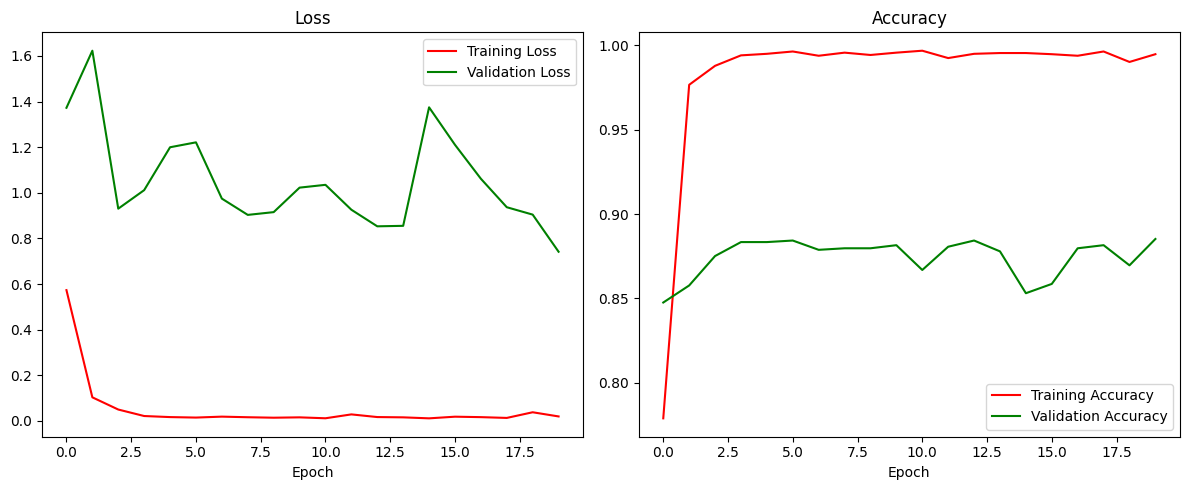

In [378]:
# Create subplots for loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', c='red')
plt.plot(val_loss, label='Validation Loss', c='green')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy', c='red')
plt.plot(val_accuracy, label='Validation Accuracy', c='green')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [379]:
# Make predictions on the validation dataset
model_4_pred_probs = lstm4.predict(test_tweet)
display(model_4_pred_probs.shape, model_4_pred_probs[:10]) # view the first 10

model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds = np.argmax(model_4_preds, axis=1)

# Calculate LSTM model results
model_4_results = calculate_results(y_true=test_sentimen,
                                    y_pred=model_4_preds)
display(model_4_results)

display(tf.squeeze(tf.round(lstm4.predict(np.array(['Pak @sandiuno dan pak @prabowo Gajinya kirim ke saya sj'])))).numpy())

35/35 [==============================] - 1s 8ms/step


(1089, 3)

array([[3.0754977e-06, 3.1944573e-06, 9.9999368e-01],
       [1.3549225e-09, 9.9999976e-01, 1.9783882e-07],
       [9.4376924e-09, 9.9999940e-01, 5.8910166e-07],
       [4.0645416e-05, 2.5238526e-06, 9.9995685e-01],
       [9.9833703e-01, 1.6515196e-03, 1.1387255e-05],
       [9.9903560e-01, 9.5931231e-04, 5.1057550e-06],
       [9.9547869e-01, 4.4257822e-03, 9.5568408e-05],
       [9.7684026e-01, 9.3957847e-03, 1.3763928e-02],
       [5.7681216e-05, 3.2691100e-06, 9.9993908e-01],
       [8.8133835e-05, 2.3807088e-05, 9.9988806e-01]], dtype=float32)

{'accuracy': 88.42975206611571,
 'precision': 0.8844814077502243,
 'recall': 0.8842975206611571,
 'f1': 0.8842998589587284}

1/1 [==============================] - 0s 23ms/step


array([0., 1., 0.], dtype=float32)

In [288]:
predicted_sentiment = []

for idx in range(len(test_tweet)):
  predicted = tf.squeeze(tf.round(lstm4.predict(np.array([test_tweet[idx]])))).numpy()
  predicted_sentiment.append(predicted)

1/1 [==============================] - 0s 16ms/step


In [289]:
predicted_dataframe['sentimen'] = test_sentimen
predicted_dataframe['predicted_sentimen'] = [np.argmax(array) for array in predicted_sentiment]
predicted_dataframe['tweet'] = test_tweet

display(predicted_dataframe)

,sentimen,predicted_sentimen,tweet
0,1,0,mau tanya impact buat negara kek gimana kalo g...
1,1,1,jokowi raja salman sepakat tingkatkan kerja sa...
2,0,0,namanya masih ada atas paradise papers bahwasa...
3,1,1,nih apa atas gaji tidak jokowi prabowo gaji ti...
4,1,0,nan
...,...,...,...
721,0,0,nyerocos dari guru besar sumitro joyohadikusum...
722,1,0,asosiasi pengusaha bumiputera nusantara se ind...
723,0,0,tidak masuk otak lu bapak jokowi nanya ekonomi...
724,0,0,bung aids bedakan startup kayak monetizing ani...


# Model 5

In [290]:
from keras.callbacks import EarlyStopping

In [291]:
tf.random.set_seed(42)

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=64, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

In [292]:
def model5():

  inputs = layers.Input(shape=(1,), dtype="string")
  x = text_vectorizer(inputs)
  layer = embedding(x)
  layer = layers.LSTM(256, activation='relu', return_sequences=True)(layer)
  layer = layers.LSTM(512, activation='relu', return_sequences=True)(layer)
  layer = layers.LSTM(512, activation='relu')(layer)
  # layer = layers.Dense(512, name='FC1')(layer)
  # layer = layers.Dense(512,)(layer)
  # layer = layers.Dense(256,)(layer)
  # layer = layers.Dense(128,)(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Dropout(0.5)(layer)
  layer = layers.Dense(3, name='out_layer')(layer)
  layer = layers.Activation('softmax')(layer)
  model = tf.keras.Model(inputs=inputs, outputs=layer)
  return model

In [293]:
lstm5 = model5()
lstm5.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
lstm5.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_932 (InputLayer)      [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 22)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 22, 64)            640000    
                                                                 
 lstm_1220 (LSTM)            (None, 22, 256)           328704    
                                                                 
 lstm_1221 (LSTM)            (None, 22, 512)           1574912   
                                                                 
 lstm_1222 (LSTM)            (None, 512)               2099200   
                                                           

In [294]:
lstm5_history = lstm5.fit(X_train, np.float32(Y_train),
                          epochs=30, # 20
                          batch_size=512, # 256
                          # callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)],
                          validation_data=(X_test, np.float32(Y_test)),)

Epoch 1/30
6/6 [==============================] - 21s 3s/step - loss: 1.0969 - accuracy: 0.3502 - val_loss: 1.0916 - val_accuracy: 0.4022
Epoch 2/30
6/6 [==============================] - 17s 3s/step - loss: 1.0775 - accuracy: 0.4108 - val_loss: 1.0644 - val_accuracy: 0.4050
Epoch 3/30
6/6 [==============================] - 17s 3s/step - loss: 1.0153 - accuracy: 0.4718 - val_loss: 1.0370 - val_accuracy: 0.4697
Epoch 4/30
6/6 [==============================] - 17s 3s/step - loss: 0.8904 - accuracy: 0.5362 - val_loss: 1.0346 - val_accuracy: 0.4931
Epoch 5/30
6/6 [==============================] - 17s 3s/step - loss: 0.7649 - accuracy: 0.5999 - val_loss: 1.0847 - val_accuracy: 0.5152
Epoch 6/30
6/6 [==============================] - 17s 3s/step - loss: 0.6449 - accuracy: 0.6677 - val_loss: 1.2261 - val_accuracy: 0.5620
Epoch 7/30
6/6 [==============================] - 17s 3s/step - loss: 0.5922 - accuracy: 0.7321 - val_loss: 1.3494 - val_accuracy: 0.5358
Epoch 8/30
6/6 [==================

In [295]:
# Make predictions on the validation dataset
model_5_pred_probs = lstm5.predict(test_tweet)
display(model_5_pred_probs.shape, model_5_pred_probs[:10]) # view the first 10

model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds = np.argmax(model_5_preds, axis=1)

# Calculate LSTM model results
model_5_results = calculate_results(y_true=test_sentimen,
                                    y_pred=model_5_preds)
display(model_5_results)

display(tf.squeeze(tf.round(lstm5.predict(np.array(['Pak @sandiuno dan pak @prabowo Gajinya kirim ke saya sj'])))).numpy())

23/23 [==============================] - 5s 197ms/step


(726, 3)

array([[3.5905237e-03, 8.3987324e-11, 9.9640948e-01],
       [3.0774632e-01, 4.4168490e-01, 2.5056875e-01],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [4.2504799e-02, 9.3898600e-01, 1.8509129e-02],
       [3.3806327e-01, 3.2997009e-01, 3.3196664e-01],
       [8.2256453e-04, 1.4923239e-07, 9.9917728e-01],
       [4.7975607e-02, 9.3398315e-01, 1.8041236e-02],
       [2.8053039e-01, 4.7996151e-01, 2.3950803e-01],
       [5.2143470e-03, 4.3177570e-05, 9.9474251e-01],
       [1.7954038e-03, 4.1251025e-07, 9.9820411e-01]], dtype=float32)

{'accuracy': 61.70798898071625,
 'precision': 0.6424454753286363,
 'recall': 0.6170798898071626,
 'f1': 0.6193891206748187}

1/1 [==============================] - 0s 26ms/step


array([0., 1., 0.], dtype=float32)

In [296]:
predicted_sentiment = []

for idx in range(len(test_tweet)):
  predicted = tf.squeeze(tf.round(lstm5.predict(np.array([test_tweet[idx]])))).numpy()
  predicted_sentiment.append(predicted)

1/1 [==============================] - 0s 23ms/step


In [297]:
predicted_dataframe['sentimen'] = test_sentimen
predicted_dataframe['predicted_sentimen'] = [np.argmax(array) for array in predicted_sentiment]
predicted_dataframe['tweet'] = test_tweet

display(predicted_dataframe)

,sentimen,predicted_sentimen,tweet
0,1,2,mau tanya impact buat negara kek gimana kalo g...
1,1,0,jokowi raja salman sepakat tingkatkan kerja sa...
2,0,0,namanya masih ada atas paradise papers bahwasa...
3,1,1,nih apa atas gaji tidak jokowi prabowo gaji ti...
4,1,0,nan
...,...,...,...
721,0,0,nyerocos dari guru besar sumitro joyohadikusum...
722,1,2,asosiasi pengusaha bumiputera nusantara se ind...
723,0,0,tidak masuk otak lu bapak jokowi nanya ekonomi...
724,0,0,bung aids bedakan startup kayak monetizing ani...


# Random Forest

In [298]:
rfc = RandomForestClassifier()

In [299]:
X_vect = text_vectorizer(X_train)
X_embedd = embedding(X_vect)

In [300]:
rfc.fit(X_vect, np.float32(Y_train))

RandomForestClassifier()

In [301]:
XT_vect = text_vectorizer(X_test)
rfc_score = rfc.score(XT_vect, np.float32(Y_test))
print(rfc_score)

0.4738292011019284


In [302]:
from sklearn.metrics import classification_report

In [303]:
y_pred = rfc.predict(XT_vect)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.42      0.43       242
           1       0.54      0.50      0.52       256
           2       0.43      0.50      0.46       228

    accuracy                           0.47       726
   macro avg       0.47      0.47      0.47       726
weighted avg       0.48      0.47      0.47       726



C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype